In [1]:
# Importing the libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
import io
import random
from subprocess import check_output



In [2]:
pip install xgboost==1.7.6

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 MB 3.7 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.1.3
    Uninstalling xgboost-2.1.3:
      Successfully uninstalled xgboost-2.1.3


In [3]:
pip install scikit-learn==1.2.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 38.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.0
    Uninstalling scikit-learn-1.6.0:
      Successfully uninstalled scikit-learn-1.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.31.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.2.0 which is incompatible.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.2.0 which is incompatible.
mlxtend 0.23.3 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.0 which is incompatible.


In [4]:
pip install imbalanced-learn==0.10.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 4.2 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0


In [5]:
pip install --upgrade xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 4.7 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 1.7.6
    Uninstalling xgboost-1.7.6:
      Successfully uninstalled xgboost-1.7.6


In [18]:
from google.colab import files
uploaded = files.upload()
import io
import pandas as pd
Fin_DIS = pd.read_csv(io.BytesIO(uploaded['Financial Distress.csv']))

Saving Financial Distress.csv to Financial Distress.csv


In [16]:
Fin_DIS.head()
Fin_DIS.tail()

,Company,Time,Financial Distress,x1,x2,x3,x4,x5,x6,x7,...,x73,x74,x75,x76,x77,x78,x79,x81,x82,x83
3667,422,10,0.0,2.2605,0.20289,0.16037,0.18588,0.17597,0.19840,2.2236,...,22.0,100.0,100.0,100.0,17.125,14.5,-7.0,0.43638,4,41
3668,422,11,0.0,1.9615,0.21644,0.20095,0.21642,0.20359,0.18987,1.9382,...,28.0,91.5,130.5,132.4,20.000,14.5,-16.0,0.43802,5,42
3669,422,12,0.0,1.7099,0.20797,0.26136,0.21399,0.19367,0.18389,1.6898,...,32.0,87.1,175.9,178.1,20.000,14.5,-20.2,0.48241,6,43
3670,422,13,0.0,1.5590,0.18545,0.30728,0.19307,0.17214,0.17068,1.5389,...,30.0,92.9,203.2,204.5,22.000,22.0,6.4,0.50077,7,44
3671,422,14,0.0,1.6148,0.17676,0.36369,0.18442,0.16955,0.19786,1.5842,...,29.0,91.7,227.5,214.5,21.000,20.5,8.6,0.61103,8,45


In [19]:
print("Number of companies:",Fin_DIS.Company.unique().shape)
Fin_DIS = Fin_DIS[Fin_DIS.columns.drop(list(Fin_DIS.filter(regex='x80')))] # Since it is a categorical feature with 37 features.


Number of companies: (422,)


In [20]:
# Creating target vector and feature matrix
target_variable = Fin_DIS.iloc[:, 2].values
for val in range(0, len(target_variable)):  # Converting target variable from continuous to binary form
    if target_variable[val] > -0.5:
        target_variable[val] = 0
    else:
        target_variable[val] = 1
predictor_variables = Fin_DIS.iloc[:, 3:].values

In [22]:
# Counting observations for healthy and bankrupt companies
healthy_count = 0
for target_val in target_variable:
    if target_val == 0:
        healthy_count += 1
bankrupt_count = len(target_variable) - healthy_count

print("Number of observations for BANKRUPT companies (1's):", bankrupt_count)
print("Number of observations for HEALTHY companies (0's):", healthy_count)

Number of observations for BANKRUPT companies (1's): 136
Number of observations for HEALTHY companies (0's): 3536


In [23]:
from sklearn.model_selection import train_test_split

predictor_train, predictor_test, target_train, target_test = train_test_split(
    predictor_variables, target_variable, test_size=0.30, random_state=0
)
predictor_train_original = predictor_train.copy()
target_train_original = target_train.copy()

In [25]:
# Augmenting data for bankrupt companies (undersampled data)
target_train_df = pd.DataFrame(target_train.reshape(-1, 1), columns=['Financial_Distress'])
predictor_train_df = pd.DataFrame(predictor_train)
training_data = pd.concat([predictor_train_df, target_train_df], axis=1)
bankrupt_subset = training_data[training_data.Financial_Distress == 1]

bankrupt_features = bankrupt_subset.iloc[:, :-1].values
feature_means = np.mean(bankrupt_features, axis=0)
feature_stds = np.std(bankrupt_features, axis=0)

num_new_samples = 1200
synthetic_data = np.zeros(shape=(num_new_samples, bankrupt_features.shape[1]))
for i in range(bankrupt_features.shape[1]):
    synthetic_data[:, i] = np.random.normal(feature_means[i], feature_stds[i], num_new_samples)

synthetic_targets = np.ones(shape=(num_new_samples, 1))  # Labels for synthetic data

predictor_augmented = np.vstack((predictor_train, synthetic_data))  # Combine original and synthetic data
target_augmented = np.vstack((target_train.reshape(-1, 1), synthetic_targets))

In [26]:
# Standardizing features
from sklearn.preprocessing import StandardScaler

feature_scaler = StandardScaler()
predictor_augmented = feature_scaler.fit_transform(predictor_augmented)
predictor_test = feature_scaler.transform(predictor_test)

In [27]:
# Model Training

# XGBoost Classifier
from xgboost import XGBClassifier
xgb_model = XGBClassifier()
xgb_model.fit(predictor_augmented, target_augmented.ravel())

# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=5, criterion='entropy')
rf_model.fit(predictor_augmented, target_augmented.ravel())

# Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier()
dt_model.fit(predictor_augmented, target_augmented.ravel())

# Naive Bayes Classifier
from sklearn.naive_bayes import GaussianNB
nb_model = GaussianNB()
nb_model.fit(predictor_augmented, target_augmented.ravel())

GaussianNB()

In [28]:
# Model Evaluation

from sklearn.metrics import confusion_matrix

# Predictions and Accuracy for each model
model_predictions = {
    "XGBoost": xgb_model.predict(predictor_test),
    "Random Forest": rf_model.predict(predictor_test),
    "Decision Tree": dt_model.predict(predictor_test),
    "Naive Bayes": nb_model.predict(predictor_test)
}

model_accuracies = {}
for model_name, predictions in model_predictions.items():
    cm = confusion_matrix(target_test, predictions)
    accuracy = (cm[0, 0] + cm[1, 1]) / len(target_test)
    model_accuracies[model_name] = accuracy
    print(f"\nAccuracy for {model_name}: {accuracy * 100:.2f}%")


Accuracy for XGBoost: 95.92%

Accuracy for Random Forest: 96.55%

Accuracy for Decision Tree: 94.28%

Accuracy for Naive Bayes: 31.85%


In [29]:
# Calculate and print precision, recall, F-score, and support for each model
from sklearn.metrics import precision_recall_fscore_support

for model_name, predictions in model_predictions.items():
    precision, recall, f_score, _ = precision_recall_fscore_support(target_test, predictions, average=None)

    print(f"\nMetrics for {model_name}:")
    print("Precision:", precision)
    print("Recall:", recall)
    print("F-Score:", f_score)
    print(f"Accuracy: {model_accuracies[model_name] * 100:.2f}%")


Metrics for XGBoost:
Precision: [0.97299814 0.42857143]
Recall: [0.98491989 0.29268293]
F-Score: [0.97892272 0.34782609]
Accuracy: 95.92%

Metrics for Random Forest:
Precision: [0.97493036 0.56      ]
Recall: [0.98963242 0.34146341]
F-Score: [0.98222638 0.42424242]
Accuracy: 96.55%

Metrics for Decision Tree:
Precision: [0.9743346 0.28     ]
Recall: [0.96606975 0.34146341]
F-Score: [0.97018457 0.30769231]
Accuracy: 94.28%

Metrics for Naive Bayes:
Precision: [0.99050633 0.04834606]
Recall: [0.29500471 0.92682927]
F-Score: [0.45461147 0.09189843]
Accuracy: 31.85%


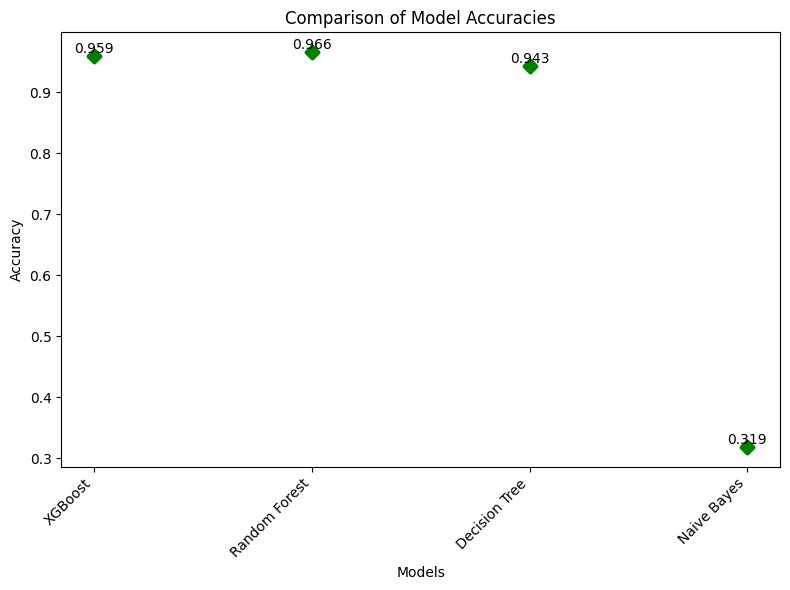

In [31]:
# Comparing Model Accuracies

import matplotlib.pyplot as plt
import numpy as np

model_names = ["XGBoost", "Random Forest", "Decision Tree", "Naive Bayes"]
accuracies = [model_accuracies[name] for name in model_names]

plt.figure(figsize=(8, 6))  # Adjust figure size if needed
plt.scatter(model_names, accuracies, color='g', marker='D', linewidths=3)

for i, accuracy in enumerate(accuracies):
    plt.annotate(f"{accuracy:.3f}", (model_names[i], accuracy), ha='center', va='bottom')

plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Comparison of Model Accuracies")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

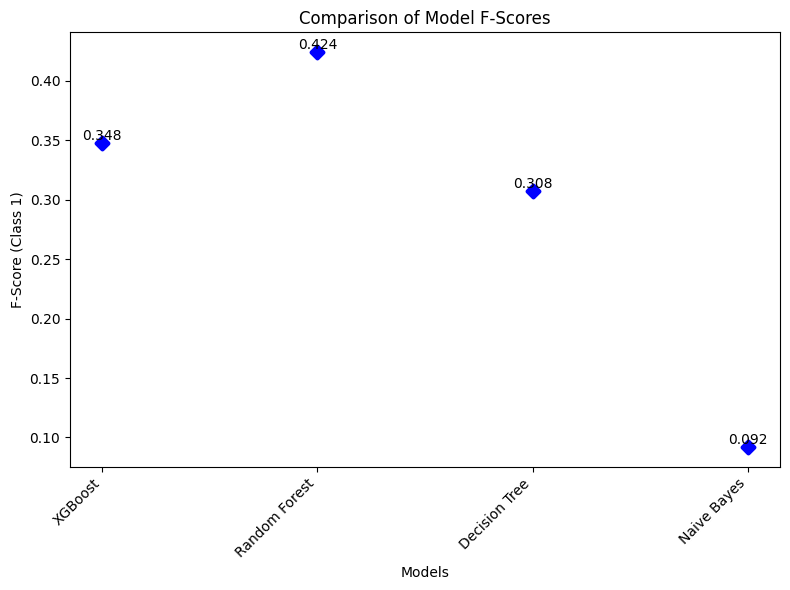

In [32]:
# Comparing Model F-Scores

import matplotlib.pyplot as plt
import numpy as np

model_names = ["XGBoost", "Random Forest", "Decision Tree", "Naive Bayes"]
f_scores = []

for model_name, predictions in model_predictions.items():
    _, _, f_score, _ = precision_recall_fscore_support(target_test, predictions, average=None)
    f_scores.append(f_score[1])  # Assuming you want F-score for class 1

plt.figure(figsize=(8, 6))
plt.scatter(model_names, f_scores, marker='D', color='b', linewidths=3)

for i, f_score in enumerate(f_scores):
    plt.annotate(f"{f_score:.3f}", (model_names[i], f_score), ha='center', va='bottom')

plt.xlabel("Models")
plt.ylabel("F-Score (Class 1)")
plt.title("Comparison of Model F-Scores")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

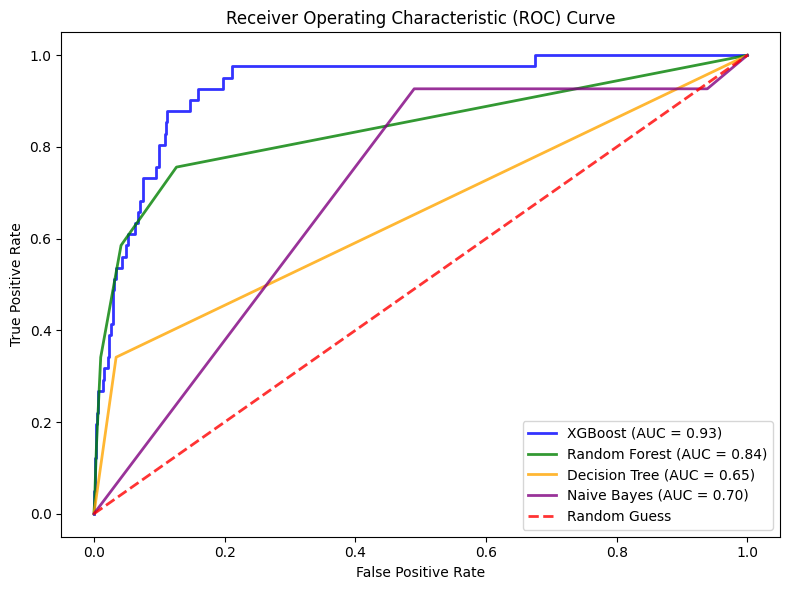

In [44]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from numpy import interp

plt.figure(figsize=(8, 6))

# Store trained models in a dictionary
trained_models = {
    "XGBoost": xgb_model,
    "Random Forest": rf_model,
    "Decision Tree": dt_model,
    "Naive Bayes": nb_model
}

# Define colors for each model
model_colors = {
    "XGBoost": "blue",
    "Random Forest": "green",
    "Decision Tree": "orange",
    "Naive Bayes": "purple"
}

for model_name in model_names:
    model = trained_models[model_name]
    probabilities = model.predict_proba(predictor_test)[:, 1]
    fpr, tpr, _ = roc_curve(target_test, probabilities)
    roc_auc = auc(fpr, tpr)

    # Use the color defined in model_colors
    plt.plot(fpr, tpr, lw=2, alpha=0.8, color=model_colors[model_name],
             label=f"{model_name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random Guess', alpha=.8)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# Applying sampling techniques



In [45]:
# Exploring Oversampling Techniques

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from collections import Counter

# Applying Random Oversampling
random_oversampler = RandomOverSampler(random_state=0)
predictor_ros, target_ros = random_oversampler.fit_resample(predictor_train, target_train)
print("Class distribution after Random Oversampling:", sorted(Counter(target_ros).items()))

# Applying SMOTE
smote_oversampler = SMOTE()
predictor_smote, target_smote = smote_oversampler.fit_resample(predictor_train, target_train)
print("Class distribution after SMOTE:", sorted(Counter(target_smote).items()))

# Applying ADASYN
adasyn_oversampler = ADASYN()
predictor_adasyn, target_adasyn = adasyn_oversampler.fit_resample(predictor_train, target_train)
print("Class distribution after ADASYN:", sorted(Counter(target_adasyn).items()))

Class distribution after Random Oversampling: [(0.0, 2475), (1.0, 2475)]
Class distribution after SMOTE: [(0.0, 2475), (1.0, 2475)]
Class distribution after ADASYN: [(0.0, 2475), (1.0, 2483)]


In [36]:
# Standardizing Features after Oversampling

# Standardize features for Random Oversampling
predictor_ros = feature_scaler.fit_transform(predictor_ros)

# Standardize features for SMOTE
predictor_smote = feature_scaler.fit_transform(predictor_smote)

# Standardize features for ADASYN
predictor_adasyn = feature_scaler.fit_transform(predictor_adasyn)

# Standardize original training features (without oversampling)
predictor_train_original = feature_scaler.fit_transform(predictor_train_original)

In [37]:
# Training XGBoost with Different Sampling Techniques

from xgboost import XGBClassifier

# XGBoost with Random Oversampling
xgb_ros_model = XGBClassifier()
xgb_ros_model.fit(predictor_ros, target_ros)

# XGBoost with SMOTE
xgb_smote_model = XGBClassifier()
xgb_smote_model.fit(predictor_smote, target_smote)

# XGBoost with ADASYN
xgb_adasyn_model = XGBClassifier()
xgb_adasyn_model.fit(predictor_adasyn, target_adasyn)

# XGBoost without Oversampling
xgb_original_model = XGBClassifier()
xgb_original_model.fit(predictor_train_original, target_train_original)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [38]:
# Making Predictions with Different Models

# Predictions using Random Oversampling
predictions_ros = xgb_ros_model.predict(predictor_test)

# Predictions using SMOTE
predictions_smote = xgb_smote_model.predict(predictor_test)

# Predictions using ADASYN
predictions_adasyn = xgb_adasyn_model.predict(predictor_test)

# Predictions without Oversampling
predictions_original = xgb_original_model.predict(predictor_test)

In [39]:
# Evaluating Model Performance

from sklearn.metrics import confusion_matrix

# Calculate confusion matrices and accuracies
model_results = {
    "Random Oversampling": (confusion_matrix(target_test, predictions_ros), predictions_ros),
    "SMOTE": (confusion_matrix(target_test, predictions_smote), predictions_smote),
    "ADASYN": (confusion_matrix(target_test, predictions_adasyn), predictions_adasyn),
    "No Oversampling": (confusion_matrix(target_test, predictions_original), predictions_original)
}

accuracies = {}
for sampling_method, (cm, _) in model_results.items():
    accuracy = (cm[0, 0] + cm[1, 1]) / len(target_test)
    accuracies[sampling_method] = accuracy
    print(f"\nAccuracy for XGBoost with {sampling_method}: {accuracy * 100:.2f}%")


Accuracy for XGBoost with Random Oversampling: 88.38%

Accuracy for XGBoost with SMOTE: 94.46%

Accuracy for XGBoost with ADASYN: 89.93%

Accuracy for XGBoost with No Oversampling: 96.28%


In [40]:
# Calculating Precision, Recall, and F-score

from sklearn.metrics import precision_recall_fscore_support

# Calculate and print metrics for each sampling method
for sampling_method, (_, predictions) in model_results.items():  # Access predictions from model_results
    precision, recall, f_score, _ = precision_recall_fscore_support(target_test, predictions, average=None)

    print(f"\nMetrics for XGBoost with {sampling_method}:")
    print("Precision:", precision)
    print("Recall:", recall)
    print("F-Score:", f_score)
    print(f"Accuracy: {accuracies[sampling_method] * 100:.2f}%")


Metrics for XGBoost with Random Oversampling:
Precision: [0.98442368 0.18705036]
Recall: [0.8934967  0.63414634]
F-Score: [0.93675889 0.28888889]
Accuracy: 88.38%

Metrics for XGBoost with SMOTE:
Precision: [0.96554935 0.14285714]
Recall: [0.97737983 0.09756098]
F-Score: [0.97142857 0.11594203]
Accuracy: 94.46%

Metrics for XGBoost with ADASYN:
Precision: [0.97690763 0.16981132]
Recall: [0.91705938 0.43902439]
F-Score: [0.94603792 0.24489796]
Accuracy: 89.93%

Metrics for XGBoost with No Oversampling:
Precision: [0.96279492 0.        ]
Recall: [1. 0.]
F-Score: [0.98104485 0.        ]
Accuracy: 96.28%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


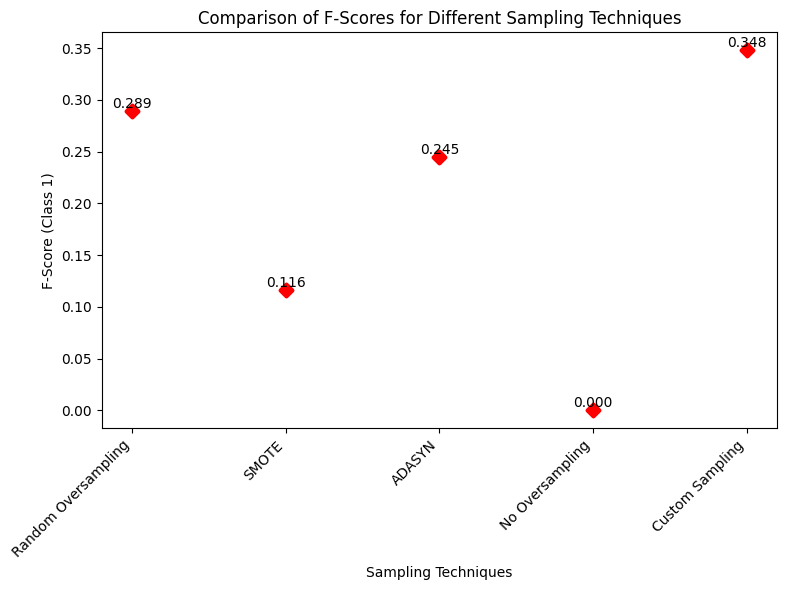

In [43]:
# Comparing F-scores for Different Sampling Techniques

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

# Assuming 'model_predictions' from cell ipython-input-27-618582f94959 contains the predictions for the initial XGBoost model
# If the variable name is different, adjust it accordingly
_, _, f_score_xgb, _ = precision_recall_fscore_support(target_test, model_predictions['XGBoost'], average=None)


sampling_methods = ["Random Oversampling", "SMOTE", "ADASYN", "No Oversampling", "Custom Sampling"]  # Add "Custom Sampling"
f_scores = [
    precision_recall_fscore_support(target_test, predictions, average=None)[2][1]  # Get F-score for class 1
    for _, predictions in model_results.values()
]

# Append the F-score for the initial XGBoost model (class 1)
f_scores.append(f_score_xgb[1])

plt.figure(figsize=(8, 6))
plt.scatter(sampling_methods, f_scores, marker='D', color='r', linewidths=3)

for i, f_score in enumerate(f_scores):
    plt.annotate(f"{f_score:.3f}", (sampling_methods[i], f_score), ha='center', va='bottom')

plt.xlabel("Sampling Techniques")
plt.ylabel("F-Score (Class 1)")
plt.title("Comparison of F-Scores for Different Sampling Techniques")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()